1.1 — Tableau récapitulatif (moyenne, médiane, écart-type, min/max, quartiles)

In [1]:
import numpy as np
import pandas as pd


df = pd.read_excel("/Users/admin/Desktop/projet_statistiques/donnees_immobilieres_extended.xlsx")
df.shape

# on garde uniquement les variables numériques, on enlève l'ID
num = df.select_dtypes(include=[np.number]).drop(columns=["ID"], errors="ignore")

recap = pd.DataFrame({
    "mean": num.mean(),
    "median": num.median(),
    "std": num.std(ddof=1),
    "min": num.min(),
    "Q1": num.quantile(0.25),
    "Q3": num.quantile(0.75),
    "max": num.max(),
})

recap


,mean,median,std,min,Q1,Q3,max
Surface_m2,116.706800,117.845,37.693819,15.21,93.240,139.6375,218.53
Chambres,2.886667,3.000,1.077760,1.00,2.000,4.0000,5.00
Annee_construction,2001.826667,2002.500,11.704841,1980.00,1991.000,2012.0000,2022.00
Distance_centre_km,16.500267,16.865,9.017430,0.83,9.105,24.6975,29.99
Etage,2.580000,2.500,1.761901,0.00,1.000,4.0000,5.00
Ascenseur,0.460000,0.000,0.500067,0.00,0.000,1.0000,1.00
Annee_vente,2019.840000,2020.000,2.288225,2015.00,2018.000,2022.0000,2023.00
Qualite_ecole,5.468667,5.600,1.868249,1.00,4.125,7.0000,10.00
Revenu_median_quartier,63.668000,63.450,9.295458,42.90,57.500,70.4750,83.90
Distance_universite,8.064000,8.300,3.746502,1.00,5.300,10.8750,17.10


1.1 — Asymétrie (skewness) et aplatissement (kurtosis) pour le prix

In [2]:
from scipy.stats import skew, kurtosis

prix = df["Prix_milliers_euros"].to_numpy()

sk = skew(prix, bias=False)
ku_excess = kurtosis(prix, fisher=True, bias=False)  # "excess" = kurtosis - 3

print("Skewness (prix):", sk)
print("Kurtosis excess (prix):", ku_excess)


Skewness (prix): 0.15623050468090552
Kurtosis excess (prix): -0.4687214247542899


skew ≈ 0.156 et kurtosis excess ≈ -0.469 → le prix n’est pas très asymétrique (plutôt proche d’une forme “normale”).

Histogrammes + boîtes à moustaches (visualiser les distributions)

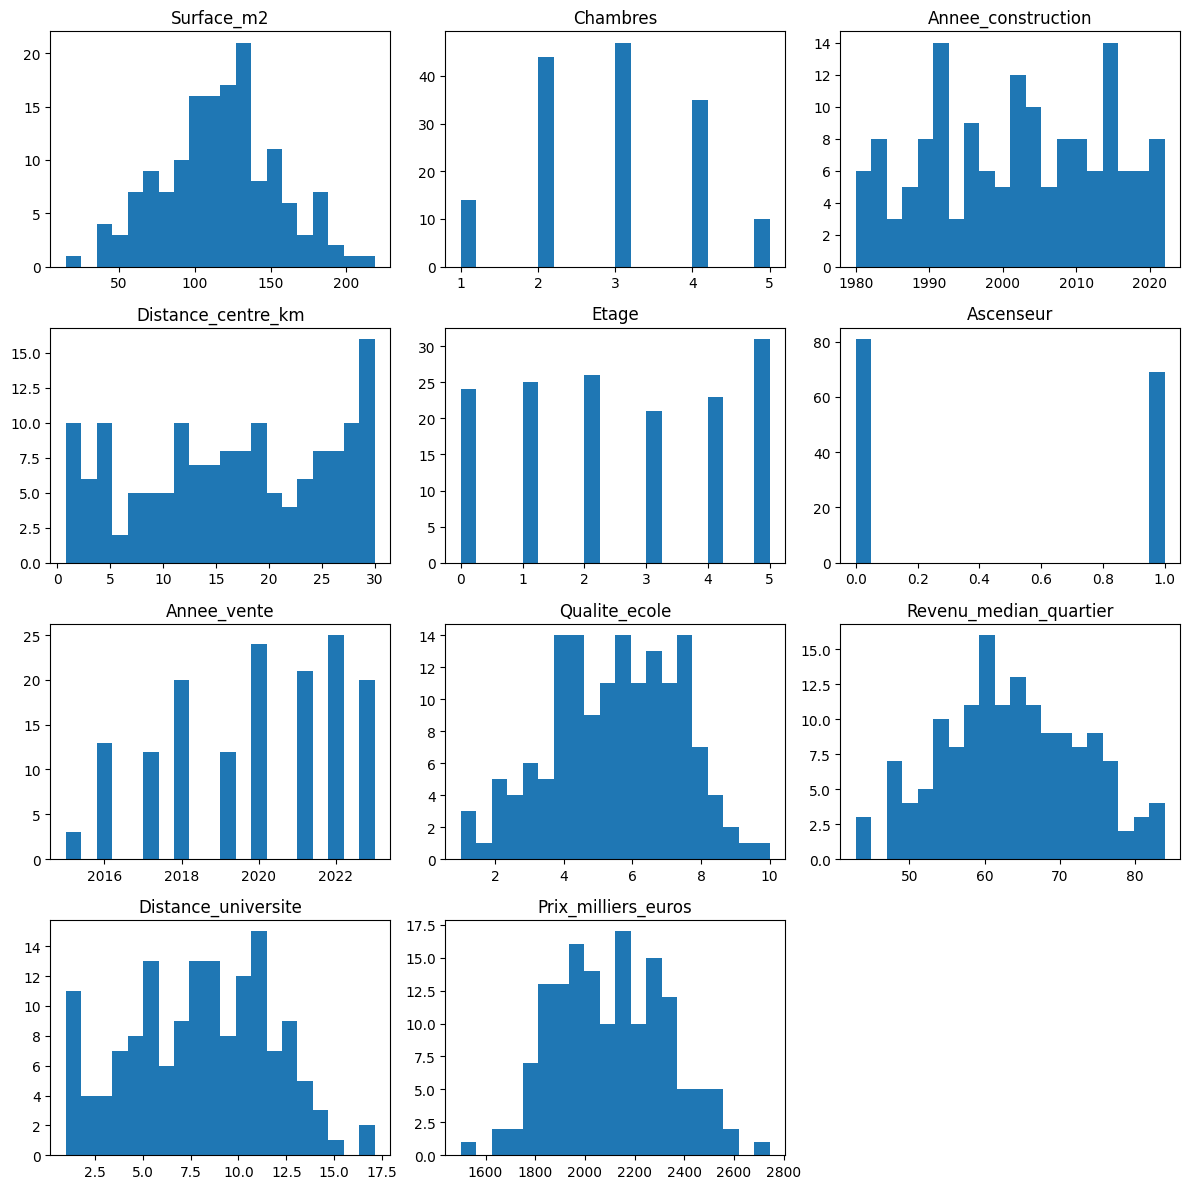

In [3]:
import matplotlib.pyplot as plt

cols = num.columns.tolist()
n = len(cols)

ncols = 3
nrows = int(np.ceil(n / ncols))

plt.figure(figsize=(4*ncols, 3*nrows))
for i, c in enumerate(cols, 1):
    plt.subplot(nrows, ncols, i)
    plt.hist(num[c].dropna(), bins=20)
    plt.title(c)
plt.tight_layout()
plt.show()


boxplots (toutes les variables numériques)

/var/folders/sb/l32lpbzn0l53j2_x5fn4htw80000gp/T/ipykernel_18188/2870928021.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([num[c].dropna() for c in cols], labels=cols, vert=False)


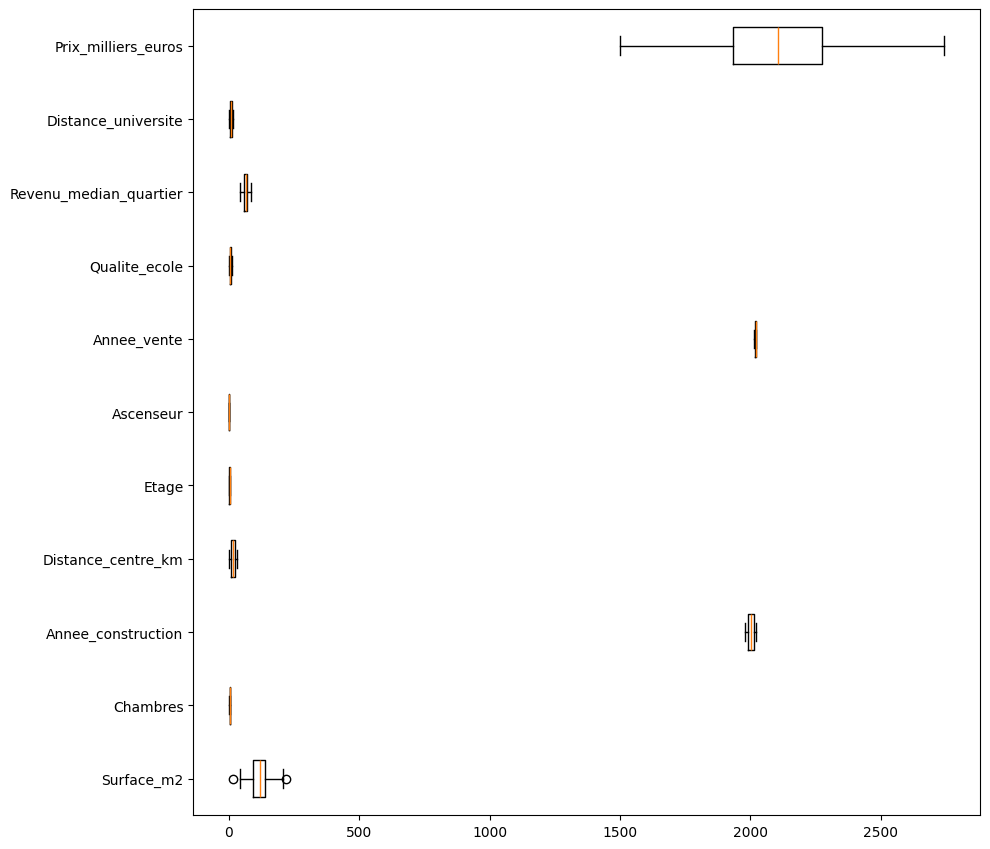

In [4]:
plt.figure(figsize=(10, 0.6*len(cols)+2))
plt.boxplot([num[c].dropna() for c in cols], labels=cols, vert=False)
plt.tight_layout()
plt.show()


Prix_milliers_euros a une dispersion importante (normal).

Pour les autres variables, on ne peut pas juger correctement des outliers sur ce graphe unique, parce que l’échelle est dominée par le prix.

Ascenseur est binaire (0/1) → boxplot peu informatif.

Pour repérer les variables à log-transformer, il faut soit faire des boxplots séparés, soit utiliser une échelle log pour les variables positives.

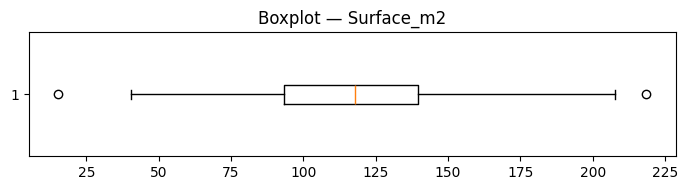

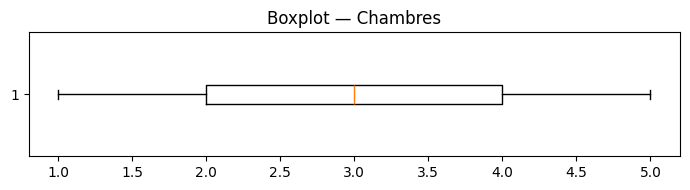

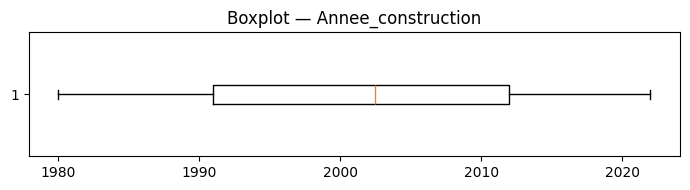

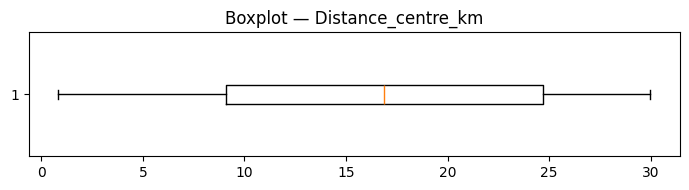

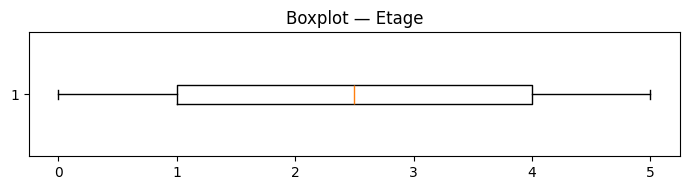

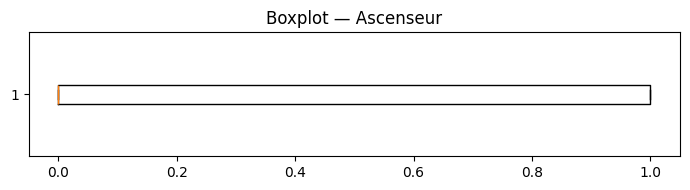

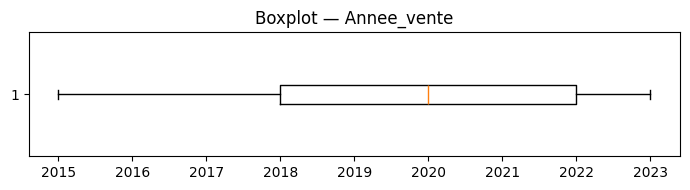

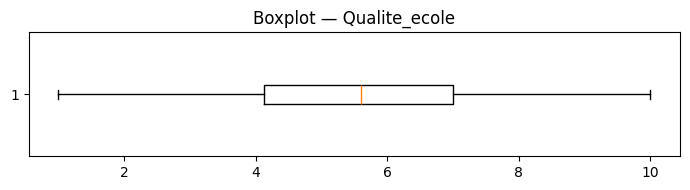

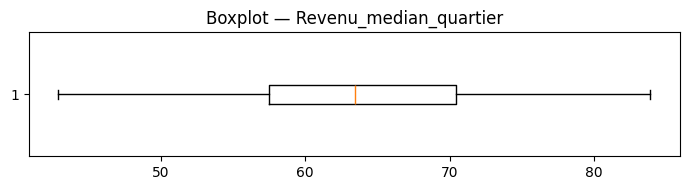

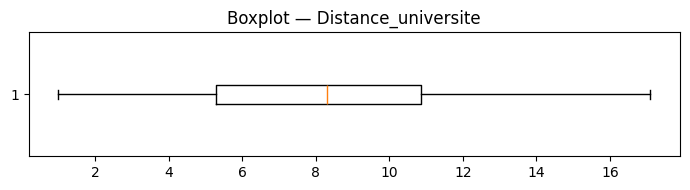

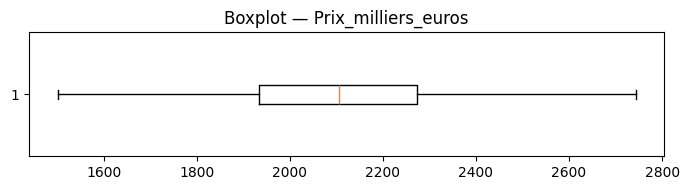

In [5]:


# variables numériques sans ID
num = df.select_dtypes(include=[np.number]).drop(columns=["ID"], errors="ignore")

for c in num.columns:
    plt.figure(figsize=(7, 2))
    plt.boxplot(num[c].dropna(), vert=False)
    plt.title(f"Boxplot — {c}")
    plt.tight_layout()
    plt.show()


Les boxplots et les coefficients d’asymétrie indiquent des distributions globalement peu asymétriques ; aucune transformation logarithmique n’est nécessaire sur cette base. 

In [6]:


num = df.select_dtypes(include=[np.number]).drop(columns=["ID"], errors="ignore")

positive_cols = [c for c in num.columns if (num[c] > 0).all()]
skews = {c: skew(num[c], bias=False) for c in positive_cols}

sorted(skews.items(), key=lambda x: abs(x[1]), reverse=True)[:10]


[('Annee_vente', np.float64(-0.32185507166808747)),
 ('Prix_milliers_euros', np.float64(0.15623050468090552)),
 ('Qualite_ecole', np.float64(-0.14505003658319754)),
 ('Distance_centre_km', np.float64(-0.14194259332354417)),
 ('Distance_universite', np.float64(-0.11641743218738826)),
 ('Chambres', np.float64(0.09814637605690635)),
 ('Annee_construction', np.float64(-0.08291889500533917)),
 ('Revenu_median_quartier', np.float64(0.051913137874346094)),
 ('Surface_m2', np.float64(0.04771679964573137))]

Les coefficients d’asymétrie sont faibles pour l’ensemble des variables (|skewness| ≤ 0.32). En particulier, le prix présente une asymétrie faible (skew ≈ 0.16) et un aplatissement négatif (kurtosis excess ≈ -0.47). Les distributions ne suggèrent pas un besoin impératif de transformation logarithmique sur la base de l’asymétrie.

In [7]:

num = df.select_dtypes(include=[np.number]).drop(columns=["ID","Ascenseur"], errors="ignore")
corr = num.corr(numeric_only=True)

corr


,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
Surface_m2,1.000000,0.590959,-0.034333,-0.074765,0.061126,0.060417,0.043832,0.013908,-0.088362,0.826731
Chambres,0.590959,1.000000,0.039398,-0.102319,0.048986,0.036140,-0.012775,0.011761,-0.089609,0.614825
Annee_construction,-0.034333,0.039398,1.000000,-0.088117,-0.044559,-0.055920,-0.009887,0.030304,-0.006250,0.068358
Distance_centre_km,-0.074765,-0.102319,-0.088117,1.000000,0.018235,0.076058,0.042029,0.111579,-0.055751,-0.306648
Etage,0.061126,0.048986,-0.044559,0.018235,1.000000,0.126383,-0.031142,0.038186,0.077101,0.128403
Annee_vente,0.060417,0.036140,-0.055920,0.076058,0.126383,1.000000,0.020798,0.007267,0.033378,0.236992
Qualite_ecole,0.043832,-0.012775,-0.009887,0.042029,-0.031142,0.020798,1.000000,0.598651,-0.444083,0.253632
Revenu_median_quartier,0.013908,0.011761,0.030304,0.111579,0.038186,0.007267,0.598651,1.000000,-0.304002,0.205779
Distance_universite,-0.088362,-0.089609,-0.006250,-0.055751,0.077101,0.033378,-0.444083,-0.304002,1.000000,-0.124521
Prix_milliers_euros,0.826731,0.614825,0.068358,-0.306648,0.128403,0.236992,0.253632,0.205779,-0.124521,1.000000


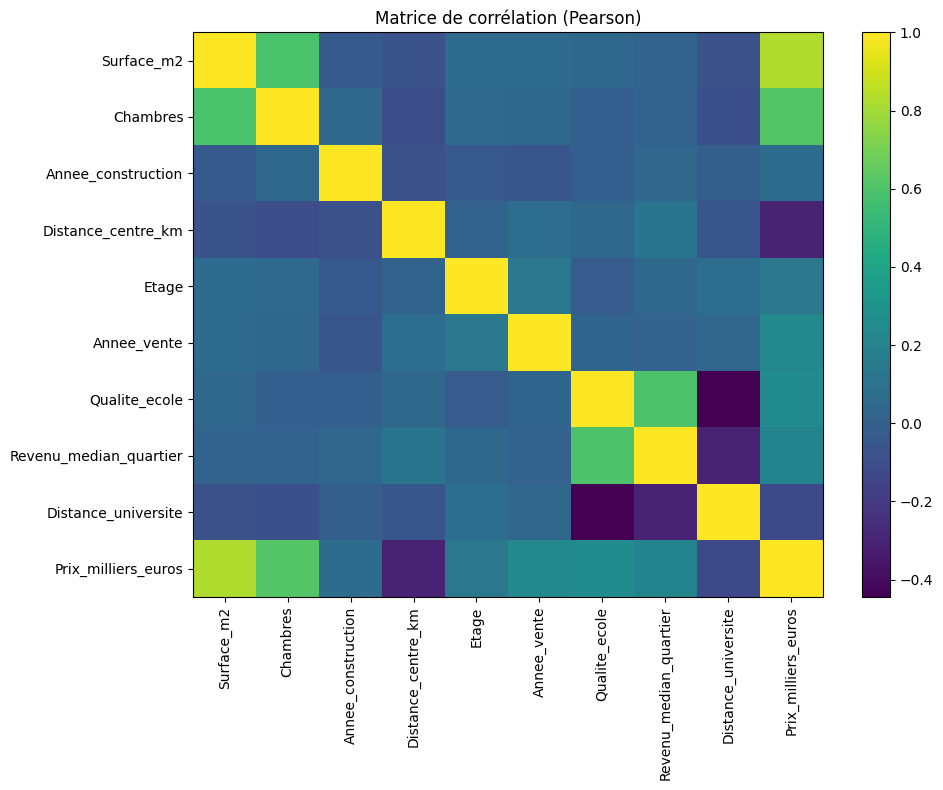

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matrice de corrélation (Pearson)")
plt.tight_layout()
plt.show()


Paires fortement corrélées (risque multicolinéarité)

In [9]:
threshold = 0.7

# on garde seulement la partie haute de la matrice (évite doublons)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

pairs = (
    upper.stack()
         .reset_index()
         .rename(columns={"level_0":"var1","level_1":"var2",0:"corr"})
)

strong_pairs = pairs.loc[pairs["corr"].abs() >= threshold].sort_values("corr", ascending=False)
strong_pairs


,var1,var2,corr
8,Surface_m2,Prix_milliers_euros,0.826731


Variable la plus “impactante” sur le prix (corrélation)

In [10]:
target = "Prix_milliers_euros"

corr_price = corr[target].drop(index=target).sort_values(key=lambda s: s.abs(), ascending=False)
corr_price


Surface_m2                0.826731
Chambres                  0.614825
Distance_centre_km       -0.306648
Qualite_ecole             0.253632
Annee_vente               0.236992
Revenu_median_quartier    0.205779
Etage                     0.128403
Distance_universite      -0.124521
Annee_construction        0.068358
Name: Prix_milliers_euros, dtype: float64

La corrélation la plus forte en valeur absolue est celle de la Surface_m2, ce qui suggère une relation linéaire forte avec le prix, sans toutefois impliquer de causalité directe à ce stade. Cette paire présente une corrélation élevée (|r| ≥ 0.7), ce qui confirme que la surface est le principal moteur du prix dans notre modèle
Le risque de multicolinéarité entre la surface et le nombre de chambres est faible à modéré. Comme le score est de 0,59, les deux variables sont suffisamment indépendantes pour que le modèle puisse estimer correctement l'influence de chacune sur le prix

In [11]:
import numpy as np
import pandas as pd
from scipy import stats

# Variables
y = df["Prix_milliers_euros"].to_numpy()
x = df["Surface_m2"].to_numpy()

n = len(y)

# Matrice X = [1, x]
X = np.column_stack([np.ones(n), x])

# Estimateur MCO beta = (X'X)^-1 X'y
XtX_inv = np.linalg.inv(X.T @ X)
beta = XtX_inv @ (X.T @ y)
b0, b1 = beta

# Prédictions et résidus
y_hat = X @ beta
u_hat = y - y_hat

# Variance résiduelle (sigma^2) et SE des coefficients
k = X.shape[1]                  # nombre de paramètres (2)
sigma2_hat = (u_hat @ u_hat) / (n - k)
var_beta = sigma2_hat * XtX_inv
se = np.sqrt(np.diag(var_beta))
se_b0, se_b1 = se

# t-stats et p-values (bilatérales)
t_stats = beta / se
dfree = n - k
p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=dfree))

# R² et R² ajusté
SST = ((y - y.mean())**2).sum()
SSE = (u_hat**2).sum()
R2 = 1 - SSE/SST
R2_adj = 1 - (1 - R2) * (n - 1) / (n - k)

# Tableau résultats
results = pd.DataFrame({
    "coef": [b0, b1],
    "std_err": [se_b0, se_b1],
    "t": t_stats,
    "p_value": p_vals
}, index=["beta0_const", "beta1_surface"])

print("R2:", R2)
print("R2_adj:", R2_adj)
results


R2: 0.6834843322527129
R2_adj: 0.6813457128760421


,coef,std_err,t,p_value
beta0_const,1519.374309,34.584475,43.932265,0.0
beta1_surface,5.042812,0.282082,17.877119,0.0


β̂1, c’est la pente : l’augmentation moyenne du prix quand la surface augmente d’1 m² (toutes choses égales… ici il n’y a que la surface).

Si la surface augmente de 1 m², alors le prix augmente en moyenne de β̂1 milliers d’euros.

En euros : β̂1 × 1 000 €.

β̂1 ≈ 5.04, alors +1 m² -->  +5.04 k€ ≈ +5 040 € en moyenne.

In [12]:


y = df["Prix_milliers_euros"].to_numpy()

vars_X = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur"]
Xraw = df[vars_X].to_numpy()

n = len(y)
X = np.column_stack([np.ones(n), Xraw])  # constante
k = X.shape[1]                           # nb paramètres (1 + 6)

# MCO
XtX_inv = np.linalg.inv(X.T @ X)
beta = XtX_inv @ (X.T @ y)

y_hat = X @ beta
u_hat = y - y_hat

# Variance résiduelle + SE
sigma2_hat = (u_hat @ u_hat) / (n - k)
var_beta = sigma2_hat * XtX_inv
se = np.sqrt(np.diag(var_beta))

# t et p-valeurs
t_stats = beta / se
p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n-k))

# R² et R² ajusté
SST = ((y - y.mean())**2).sum()
SSE = (u_hat**2).sum()
R2 = 1 - SSE/SST
R2_adj = 1 - (1 - R2) * (n - 1) / (n - k)

# Table
index = ["const"] + vars_X
res = pd.DataFrame({"coef": beta, "std_err": se, "t": t_stats, "p_value": p_vals}, index=index)

print("R2:", R2)
print("R2_adj:", R2_adj)
res


R2: 0.7886569640697604
R2_adj: 0.7797894241006594


,coef,std_err,t,p_value
const,-1679.490797,1535.673028,-1.093651,2.759468e-01
Surface_m2,4.387871,0.292434,15.004659,0.000000e+00
Chambres,33.920464,10.227872,3.316473,1.155769e-03
Annee_construction,1.609340,0.765256,2.103009,3.721665e-02
Distance_centre_km,-6.144640,0.992097,-6.193586,5.902425e-09
Etage,12.254026,5.048919,2.427059,1.646575e-02
Ascenseur,55.514127,17.920113,3.097867,2.346952e-03


R² et R² ajusté

R² = 0.7887 ,
R² ajusté = 0.7798
--> le modèle explique ~79% de la variance du prix, et ~78% après pénalisation du nombre de variables.

1) Tous les coefficients sont-ils significatifs ?

À 5% :

Significatifs : Surface_m2, Chambres, Annee_construction, Distance_centre_km, Etage, Ascenseur (p < 0.05).

Non significatif : la constante (p = 0.276).


2) Impact marginal de chaque variable (ceteris paribus)

Surface_m2 : +4.3879 k€ par m² ≈ +4 388 € / m²

Chambres : +33.9205 k€ par chambre ≈ +33 920 €

Année_construction : +1.6093 k€ par année ≈ +1 609 € (plus récent = plus cher)

Distance_centre_km : -6.1446 k€ par km ≈ -6 145 € / km (plus loin = moins cher)

Etage : +12.2540 k€ par étage ≈ +12 254 €

Ascenseur : +55.5141 k€ ≈ +55 514 €

(Tous ces effets sont “à caractéristiques identiques”, i.e. conditionnellement aux autres variables du modèle.)

3) Ascenseur : comment interpréter le coefficient ?

Ascenseur est binaire (0/1).
Donc β̂_ascenseur = 55.5 k€ signifie :

À surface, nombre de chambres, année de construction, distance au centre et étage identiques, un appartement avec ascenseur est en moyenne ~55 500 € plus cher qu’un appartement sans ascenseur.

4) Différence entre R² et R² ajusté

R² augmente mécaniquement quand on ajoute des variables.
R² ajusté pénalise l’ajout de variables : il n’augmente que si les nouvelles variables apportent une amélioration réelle.
Ici, R²_adj est un peu plus bas (0.7798 vs 0.7887), ce qui est normal.

---> Les signes sont conformes à l’intuition économique : la surface, le nombre de chambres, l’étage et la présence d’ascenseur augmentent le prix, tandis que l’éloignement du centre le réduit. Tous les coefficients (hors constante) sont significatifs au seuil de 5%

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y = df["Prix_milliers_euros"].to_numpy()

vars_X = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur"]
X = df[vars_X].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1) Niveau
m_lvl = LinearRegression().fit(X_train, y_train)
yhat_lvl = m_lvl.predict(X_test)
rmse_lvl = np.sqrt(mean_squared_error(y_test, yhat_lvl))
r2_lvl = r2_score(y_test, yhat_lvl)

# 2) Semi-log : log(y) ~ X
ylog_train = np.log(y_train)
ylog_test = np.log(y_test)

m_semilog = LinearRegression().fit(X_train, ylog_train)
ylog_hat = m_semilog.predict(X_test)
yhat_semilog = np.exp(ylog_hat)
rmse_semilog = np.sqrt(mean_squared_error(y_test, yhat_semilog))
r2_semilog_logspace = r2_score(ylog_test, ylog_hat)

# 3) Log-log mixte : log(y) ~ log(X_pos) + Etage + Ascenseur
log_cols = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km"]
level_cols = ["Etage","Ascenseur"]

X_log = df[log_cols].to_numpy()
X_lvl = df[level_cols].to_numpy()

X3 = np.column_stack([np.log(X_log), X_lvl])

X3_train, X3_test, _, _ = train_test_split(X3, y, test_size=0.2, random_state=42)

m_loglog = LinearRegression().fit(X3_train, ylog_train)
ylog_hat3 = m_loglog.predict(X3_test)
yhat_loglog = np.exp(ylog_hat3)

rmse_loglog = np.sqrt(mean_squared_error(y_test, yhat_loglog))
r2_loglog_logspace = r2_score(ylog_test, ylog_hat3)

compare = pd.DataFrame({
    "Modele": ["Niveau (y)", "Semi-log (log(y))", "Log-log mixte"],
    "RMSE_prix_k€": [rmse_lvl, rmse_semilog, rmse_loglog],
    "R2_test_niveau": [r2_lvl, np.nan, np.nan],
    "R2_test_log": [np.nan, r2_semilog_logspace, r2_loglog_logspace],
})
compare


,Modele,RMSE_prix_k€,R2_test_niveau,R2_test_log
0,Niveau (y),105.048447,0.7257,NaN
1,Semi-log (log(y)),107.392699,NaN,0.718109
2,Log-log mixte,103.552979,NaN,0.720140


 comparaison des trois modèles

Sur l'échantillon test :

Niveau (y) : RMSE ≈ 105.05 k€, 
𝑅
2 (niveau) ≈ 0.726

Semi-log (log(y)) : RMSE ≈ 107.39 k€ (un peu pire), 
𝑅
2(log) ≈ 0.718

Log-log mixte : RMSE ≈ 103.55 k€ (meilleur), 
𝑅
2(log) ≈ 0.720

Donc en performance prédictive (RMSE sur le prix) :
Log-log mixte > Niveau > Semi-log.

2) Modèle le plus approprié et pourquoi ?

Le plus approprié ici : le log-log mixte, parce que :

il a le RMSE le plus faible (≈ 103.55 k€), donc meilleure prédiction du prix,

il permet une interprétation économique claire pour plusieurs variables (coefficients en élasticités),

et il gère souvent mieux la non-linéarité / hétéroscédasticité (à confirmer dans la partie diagnostics).


Les trois spécifications ont été comparées sur un échantillon test via le RMSE des prix prédits. Le modèle log-log mixte obtient la meilleure performance (RMSE ≈ 103.6 k€), devant le modèle en niveau (≈ 105.0 k€) et le semi-log (≈ 107.4 k€). Il est donc le plus approprié ici, tout en offrant une interprétation en termes d’élasticités pour les variables log-transformées.



In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

vars_X = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur",
          "Qualite_ecole","Revenu_median_quartier"]  
X = df[vars_X].to_numpy()

# standardisation (recommandé pour stabilité numérique)
Xs = StandardScaler().fit_transform(X)

vif_list = []
for j in range(Xs.shape[1]):
    yj = Xs[:, j]
    Xj = np.delete(Xs, j, axis=1)
    r2_j = LinearRegression().fit(Xj, yj).score(Xj, yj)
    vif = 1 / (1 - r2_j)
    vif_list.append(vif)

vif_df = pd.DataFrame({"variable": vars_X, "VIF": vif_list}).sort_values("VIF", ascending=False)
vif_df


,variable,VIF
7,Revenu_median_quartier,1.599066
6,Qualite_ecole,1.579154
0,Surface_m2,1.564096
1,Chambres,1.561369
3,Distance_centre_km,1.038228
5,Ascenseur,1.034996
2,Annee_construction,1.030751
4,Etage,1.019663


Le VIF max est ~1.60 (Revenu_median_quartier), puis Qualite_ecole ~1.58, Surface_m2 ~1.56, Chambres ~1.56.

Tous les autres sont ~1.02–1.04.

Interprétation : aucune multicolinéarité préoccupante (on est très loin des seuils 5 ou 10).
Il ne faut supprimer aucune variable pour “réduire le VIF” : ce serait inutile.

Les VIF calculés sont proches de 1 (VIF max ≈ 1.60), ce qui indique une multicolinéarité très faible entre les régresseurs. Il n’y a donc pas de variable présentant un VIF élevé, et il n’est pas nécessaire d’en supprimer sur ce critère.

Faut-il supprimer certaines variables ?

Supprimer des variables uniquement pour réduire la multicolinéarité n’est pas recommandé dans ce cas : la multicolinéarité augmente surtout les écarts-types (donc réduit la précision), mais ne crée pas de biais si le modèle est correctement spécifié. En revanche, supprimer une variable pertinente peut induire un biais de variable omise.

Définition du biais de variable omise

Le biais de variable omise apparaît lorsqu’une variable qui influence le prix est exclue du modèle et qu’elle est corrélée avec une ou plusieurs variables incluses. L’effet de la variable omise est alors attribué à tort aux variables incluses, ce qui biaise les coefficients estimés.



In [15]:

t_dist = res.loc["Distance_centre_km", "t"]
p_two = res.loc["Distance_centre_km", "p_value"]

# unilatéral gauche : H1 beta < 0
p_one = p_two / 2 if t_dist < 0 else 1 - (p_two / 2)

print("t =", t_dist)
print("p (bilat) =", p_two)
print("p (unilat gauche) =", p_one)


t = -6.1935859520438905
p (bilat) = 5.90242477116476e-09
p (unilat gauche) = 2.95121238558238e-09


Test unilatéral : effet négatif de la distance au centre

Statistique t : t = -6.1936

p-valeur bilatérale : 5.90×10⁻⁹

p-valeur unilatérale (gauche) : 2.95×10⁻⁹




On teste H0 : β_distance ≥ 0 contre H1 : β_distance < 0. La statistique t vaut -6.19 et la p-valeur unilatérale est 2.95×10⁻⁹ ; on rejette donc H0 et on conclut que la distance au centre a un effet négatif significatif sur le prix.

In [16]:

y = df["Prix_milliers_euros"].to_numpy()
n = len(y)

vars_X = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur"]
Xraw = df[vars_X].to_numpy()

# Modèle complet
X_full = np.column_stack([np.ones(n), Xraw])
beta_full = np.linalg.inv(X_full.T @ X_full) @ (X_full.T @ y)
u_full = y - X_full @ beta_full
SSE_full = (u_full**2).sum()

# Modèle restreint (constante seule)
X_res = np.ones((n,1))
beta_res = np.linalg.inv(X_res.T @ X_res) @ (X_res.T @ y)
u_res = y - X_res @ beta_res
SSE_res = (u_res**2).sum()

q = len(vars_X)          # restrictions = 6
k_full = X_full.shape[1] # paramètres complet = 7
df1 = q
df2 = n - k_full

F = ((SSE_res - SSE_full)/df1) / (SSE_full/df2)
pF = 1 - stats.f.cdf(F, df1, df2)

print("F_global =", F)
print("p-value =", pF)


F_global = 88.93751444231926
p-value = 1.1102230246251565e-16


Le test F global de H0 : β1=…=β6=0 donne F = 88.94 avec p-value = 1.11×10⁻¹⁶. On rejette donc H0 : les variables explicatives sont conjointement significatives.
Le modèle est globalement significatif (au moins un coefficient ≠ 0) et les variables expliquent significativement le prix.


In [17]:

y = df["Prix_milliers_euros"].to_numpy()
n = len(y)

base = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur"]
extra = ["Qualite_ecole","Revenu_median_quartier"]

Xb = np.column_stack([np.ones(n), df[base].to_numpy()])
Xe = np.column_stack([np.ones(n), df[base + extra].to_numpy()])

# SSE base
beta_b = np.linalg.inv(Xb.T @ Xb) @ (Xb.T @ y)
u_b = y - Xb @ beta_b
SSE_b = (u_b**2).sum()

# SSE enrichi
beta_e = np.linalg.inv(Xe.T @ Xe) @ (Xe.T @ y)
u_e = y - Xe @ beta_e
SSE_e = (u_e**2).sum()

q = len(extra)     # 2 restrictions
k_e = Xe.shape[1]  # 9 paramètres
df1 = q
df2 = n - k_e

F = ((SSE_b - SSE_e)/df1) / (SSE_e/df2)
pF = 1 - stats.f.cdf(F, df1, df2)

print("F_ajout =", F)
print("p-value =", pF)


F_ajout = 28.661603251371634
p-value = 3.590150399190861e-11


Test d’ajout : Qualite_ecole + Revenu_median_quartier

Hypothèses :

H0 : β_Qualite = β_Revenu = 0

H1 : au moins un des deux ≠ 0

Résultat :

F_ajout = 28.66

p-value = 3.59×10⁻¹¹
On rejette H0 → ajouter Qualite_ecole et Revenu améliore significativement le modèle.

Plusieurs tests t séparés augmentent le risque d’erreur de type I (tests multiples) et ne testent pas une hypothèse conjointe. Le test F permet de tester simultanément plusieurs restrictions, en tenant compte des corrélations entre estimateurs, avec un niveau de test correctement contrôlé.

In [18]:
import numpy as np
from scipy import stats

def ols_sse(y, X):
    """Retourne la somme des carrés des résidus (SSE) pour une régression OLS.
    Hypothèse : X contient déjà une constante (colonne de 1).
    """
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    resid = y - X @ beta
    sse = float(resid.T @ resid)
    return sse, beta

# --- Paramètre de rupture (COVID)
break_year = 2020

# Variable dépendante
y = df["Prix_milliers_euros"].to_numpy()

# Variables explicatives (mêmes contrôles que le modèle multiple)
vars_X = [
    "Surface_m2", "Chambres", "Annee_construction", "Distance_centre_km",
    "Etage", "Ascenseur", "Qualite_ecole", "Revenu_median_quartier"
]

# Matrice X avec constante (modèle "pooled" = tout l'échantillon)
X = df[vars_X].to_numpy()
X = np.column_stack([np.ones(len(df)), X])   # ajoute la constante
k = X.shape[1]                               # nb de paramètres = constante + variables

# --- Split pré/post COVID (selon Annee_vente)
mask_pre  = (df["Annee_vente"] < break_year).to_numpy()
mask_post = (df["Annee_vente"] >= break_year).to_numpy()

y_pre,  X_pre  = y[mask_pre],  X[mask_pre]
y_post, X_post = y[mask_post], X[mask_post]

n1, n2 = len(y_pre), len(y_post)

# SSE du modèle pooled (contraint : mêmes coefficients avant/après)
SSE_pooled, _ = ols_sse(y, X)

# SSE des deux modèles séparés (un avant, un après)
SSE_pre,  _ = ols_sse(y_pre,  X_pre)
SSE_post, _ = ols_sse(y_post, X_post)

# --- Statistique de Chow
num = (SSE_pooled - (SSE_pre + SSE_post)) / k
den = (SSE_pre + SSE_post) / (n1 + n2 - 2*k)
F = num / den
p_value = 1 - stats.f.cdf(F, dfn=k, dfd=(n1 + n2 - 2*k))

print(f"n_pre = {n1} | n_post = {n2}")
print("Chow F =", F)
print("p-value =", p_value)


n_pre = 60 | n_post = 90
Chow F = 7.412147208377636
p-value = 1.0368693570406151e-08


Un test de Chow avec rupture en 2020 donne F = 7.41 (p = 1.04×10⁻⁸) pour n_pre = 60 et n_post = 90. On rejette donc l’hypothèse de stabilité structurelle : la relation entre le prix et les caractéristiques du bien diffère significativement entre la période pré-COVID et post-COVID

Variables utilisées dans le test de Chow (contrôles X) : Surface_m2, Chambres, Annee_construction, Distance_centre_km, Etage, Ascenseur, Qualite_ecole, Revenu_median_quartier.

Pourquoi “Annee_vente” n’est pas dans X ?
Ici, Annee_vente sert à définir la rupture (pré-2020 vs post-2020). On teste si les coefficients (intercept + pentes) changent entre ces deux périodes.  


Cette rupture suggère que l’estimation d’un modèle unique sur toute la période peut masquer des effets différents avant/après COVID. Il est pertinent d’estimer des modèles séparés (pré/post), ou d’introduire une variable muette post-COVID ainsi que des interactions (post×X) afin de permettre des pentes différentes

Notre test de Chow révèle une rupture structurelle très significative ($p < 0,001$). Cela démontre que la pandémie n'a pas seulement fait varier les prix globalement, elle a redéfini la valeur relative des caractéristiques des logements. Par exemple, l'importance d'une pièce supplémentaire ou l'impact de l'éloignement du centre-ville ne sont plus perçus de la même manière par les acquéreurs après 2020

Est-ce qu’il faut estimer des modèles séparés ?

c’est justifié dans ce cas  (vu la p-value). 
on peut : estimer 2 régressions (pré et post),

comparer les coefficients clés (surface, distance, revenu/quartier).

In [19]:

def ols_table(y, X, names):
    """
    OLS avec constante déjà incluse dans X.
    Retourne un DataFrame avec coef, std_err, t, p_value.
    """
    n, k = X.shape
    XtX_inv = np.linalg.inv(X.T @ X)
    beta = XtX_inv @ (X.T @ y)
    resid = y - X @ beta
    SSE = float(resid.T @ resid)
    sigma2 = SSE / (n - k)
    var_beta = sigma2 * XtX_inv
    se = np.sqrt(np.diag(var_beta))
    t_stats = beta / se
    p_vals = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n-k))

    out = pd.DataFrame(
        {"coef": beta, "std_err": se, "t": t_stats, "p_value": p_vals},
        index=names
    )
    return out

break_year = 2020

vars_X = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur",
          "Qualite_ecole","Revenu_median_quartier"]

y = df["Prix_milliers_euros"].to_numpy()
Xraw = df[vars_X].to_numpy()
X = np.column_stack([np.ones(len(df)), Xraw])
names = ["const"] + vars_X

mask_post = (df["Annee_vente"] >= break_year).to_numpy()
mask_pre = ~mask_post

# Tables séparées
tab_pre  = ols_table(y[mask_pre],  X[mask_pre],  names)
tab_post = ols_table(y[mask_post], X[mask_post], names)

# Tableau comparatif côte à côte
compare_pre_post = pd.concat(
    [tab_pre.add_prefix("pre_"), tab_post.add_prefix("post_")],
    axis=1
)

compare_pre_post


,pre_coef,pre_std_err,pre_t,pre_p_value,post_coef,post_std_err,post_t,post_p_value
const,-533.360588,2022.815700,-0.263672,7.930949e-01,-2648.241028,1418.552142,-1.866862,6.553907e-02
Surface_m2,4.383891,0.336662,13.021636,0.000000e+00,3.979526,0.295788,13.453986,0.000000e+00
Chambres,36.941786,12.573778,2.938002,4.949489e-03,34.474073,9.223586,3.737600,3.448609e-04
Annee_construction,0.870164,0.997647,0.872217,3.871782e-01,2.018696,0.711381,2.837713,5.739990e-03
Distance_centre_km,-6.828715,1.215025,-5.620225,8.019560e-07,-7.493227,0.929624,-8.060490,5.709655e-12
Etage,12.211644,6.125807,1.993475,5.157132e-02,6.478861,4.597909,1.409088,1.626366e-01
Ascenseur,50.370160,21.304967,2.364245,2.191230e-02,54.029343,16.955761,3.186489,2.046161e-03
Qualite_ecole,17.599913,7.079209,2.486141,1.623041e-02,23.130945,5.851651,3.952892,1.642721e-04
Revenu_median_quartier,2.873751,1.378351,2.084919,4.210150e-02,2.344103,1.210149,1.937037,5.622712e-02


Après la détection d’une rupture structurelle en 2020 (test de Chow), nous estimons deux régressions séparées pré/post-COVID. Les coefficients ne sont pas identiques : certaines variables (par ex. surface, distance au centre, revenu/qualité du quartier) présentent des effets marginaux différents selon la période, ce qui confirme que le modèle ‘poolé’ masque des dynamiques distinctes

L'analyse comparative révèle que la crise du COVID-19 n'a pas seulement modifié les prix, elle a déplacé les curseurs de valeur. Si la surface reste le socle du prix, on observe une exigence accrue sur la qualité intrinsèque du bien (année de construction) et sur la qualité des services de proximité (écoles), dont l'impact financier a bondi de plus de 30%. À l'inverse, des critères classiques comme l'étage ont perdu de leur superbe. Le marché post-2020 est un marché de 'valeur refuge' où la qualité du bâti et l'emplacement social priment sur le reste.

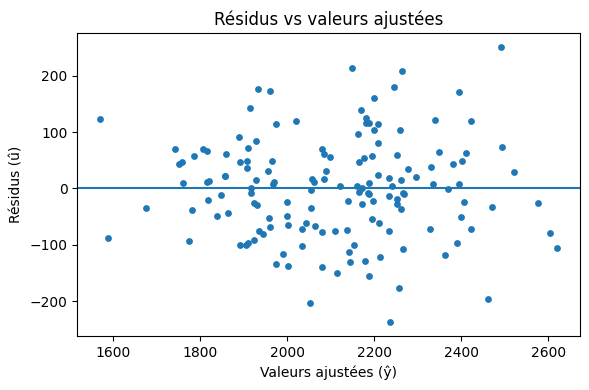

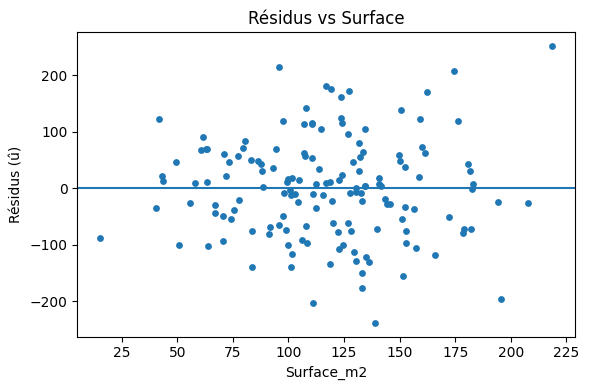

In [20]:

# Choisis ton modèle (ici: riche)
vars_X = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur",
          "Qualite_ecole","Revenu_median_quartier"]

y = df["Prix_milliers_euros"].to_numpy()
Xraw = df[vars_X].to_numpy()
X = np.column_stack([np.ones(len(df)), Xraw])

# OLS
beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
y_hat = X @ beta
u = y - y_hat

# Résidus vs valeurs ajustées
plt.figure(figsize=(6,4))
plt.scatter(y_hat, u, s=15)
plt.axhline(0)
plt.xlabel("Valeurs ajustées (ŷ)")
plt.ylabel("Résidus (û)")
plt.title("Résidus vs valeurs ajustées")
plt.tight_layout()
plt.show()

# Résidus vs Surface (souvent révélateur)
plt.figure(figsize=(6,4))
plt.scatter(df["Surface_m2"], u, s=15)
plt.axhline(0)
plt.xlabel("Surface_m2")
plt.ylabel("Résidus (û)")
plt.title("Résidus vs Surface")
plt.tight_layout()
plt.show()


visuellement, l’hypothèse d’homoscédasticité est discutable → on teste formellement (Breusch–Pagan) et on reporte des SE robustes / WLS:

Les nuages ‘résidus vs surface’ et ‘résidus vs valeurs ajustées’ ne montrent pas de structure non-linéaire marquée, mais la dispersion des résidus semble légèrement augmenter pour des valeurs élevées de surface/ŷ, ce qui suggère une hétéroscédasticité possible. Nous la testons formellement et utilisons des corrections robustes/WLS.

In [21]:

# régression auxiliaire : u^2 ~ X
u2 = u**2
Z = X  # on réutilise les mêmes variables explicatives (avec constante)

gamma = np.linalg.inv(Z.T @ Z) @ (Z.T @ u2)
u2_hat = Z @ gamma
v = u2 - u2_hat

SST = ((u2 - u2.mean())**2).sum()
SSE = (v**2).sum()
R2_aux = 1 - SSE/SST

LM = len(u2) * R2_aux
df_bp = Z.shape[1] - 1  # on enlève la constante
p_bp = 1 - stats.chi2.cdf(LM, df=df_bp)

print("Breusch–Pagan LM =", LM)
print("df =", df_bp)
print("p-value =", p_bp)


Breusch–Pagan LM = 11.995091809363473
df = 8
p-value = 0.15142300855774327


Le test de Breusch–Pagan donne LM = 12.00 (df = 8) avec p = 0.151. On ne rejette donc pas l’hypothèse d’homoscédasticité au seuil de 5% : l’évidence d’hétéroscédasticité n’est pas statistiquement significative.

Bien qu'un examen visuel des résidus suggérait une légère hétéroscédasticité pour les grandes surfaces, le test de Breusch-Pagan ($LM = 12,00$ ; $p = 0,15$) ne permet pas de rejeter l'hypothèse d'homoscédasticité. Par conséquent, les écarts-types classiques et les tests de Student présentés dans notre analyse sont statistiquement fiables et ne nécessitent pas de correction robuste impérative

In [22]:

n, k = X.shape
XtX_inv = np.linalg.inv(X.T @ X)

# HC1 robust variance: (n/(n-k)) * (X' diag(u^2) X)
S = (X.T * (u**2)) @ X
V_hc1 = (n/(n-k)) * (XtX_inv @ S @ XtX_inv)

se_ols = np.sqrt(np.diag(((u @ u)/(n-k)) * XtX_inv))
se_hc1 = np.sqrt(np.diag(V_hc1))

t_ols = beta / se_ols
p_ols = 2 * (1 - stats.t.cdf(np.abs(t_ols), df=n-k))

t_hc1 = beta / se_hc1
p_hc1 = 2 * (1 - stats.t.cdf(np.abs(t_hc1), df=n-k))

names = ["const"] + vars_X
tab_compare = pd.DataFrame({
    "coef": beta,
    "se_OLS": se_ols,
    "p_OLS": p_ols,
    "se_Robust_HC1": se_hc1,
    "p_Robust_HC1": p_hc1
}, index=names)

tab_compare


,coef,se_OLS,p_OLS,se_Robust_HC1,p_Robust_HC1
const,-1707.767991,1304.551005,1.926350e-01,1379.383029,2.177489e-01
Surface_m2,4.284023,0.249028,0.000000e+00,0.258126,0.000000e+00
Chambres,35.844089,8.701953,6.452415e-05,8.618897,5.530564e-05
Annee_construction,1.491174,0.651024,2.347539e-02,0.690291,3.244649e-02
Distance_centre_km,-6.614876,0.848105,1.253442e-12,0.897129,1.293432e-11
Etage,12.307991,4.301626,4.862670e-03,4.465068,6.615208e-03
Ascenseur,46.897429,15.269574,2.558045e-03,15.083555,2.270268e-03
Qualite_ecole,20.843369,5.048511,6.218507e-05,4.931677,4.242756e-05
Revenu_median_quartier,2.654251,1.021053,1.032868e-02,0.988373,8.111909e-03


Bien que le test de Breusch–Pagan ne rejette pas l’homoscédasticité (p = 0.151), nous comparons les MCO standard et les MCO avec écarts-types robustes (HC1). Les écarts-types robustes sont proches des écarts-types classiques et les conclusions de significativité ne changent pas : les variables principales (surface, distance au centre, etc.) restent significatives. Les résultats apparaissent donc robustes

WLS n’est pas indispensable ici ; on peut le présenter comme une vérification ou une alternative, mais la correction robuste suffit.

In [23]:

rmse_ols = np.sqrt(np.mean((y - y_hat)**2))

w = 1/(df["Surface_m2"].to_numpy()**2)
sw = np.sqrt(w)
Xw = X * sw[:, None]
yw = y * sw
beta_wls = np.linalg.inv(Xw.T @ Xw) @ (Xw.T @ yw)
y_hat_wls = X @ beta_wls
rmse_wls = np.sqrt(np.mean((y - y_hat_wls)**2))

print("RMSE OLS:", rmse_ols)
print("RMSE WLS:", rmse_wls)


RMSE OLS: 88.82657750176296
RMSE WLS: 92.81967687104635


L'examen de la structure des erreurs confirme la validité de l'estimation par les Moindres Carrés Ordinaires. Bien que nous ayons testé une approche par Moindres Carrés Pondérés (WLS) pour traiter une éventuelle hétéroscédasticité liée à la surface, celle-ci dégrade la performance globale du modèle (RMSE en hausse de 4,5%). La stabilité des écarts-types robustes HC1, couplée au test de Breusch-Pagan, nous permet de conclure que les MCO standards offrent l'estimation la plus efficace et la plus fiable des déterminants du prix immobilier dans notre échantillon.

In [24]:
#Test simple : Durbin-Watson

order = np.argsort(df["Annee_vente"].to_numpy())
u_ord = u[order]

dw = np.sum(np.diff(u_ord)**2) / np.sum(u_ord**2)
print("Durbin–Watson =", dw)


Durbin–Watson = 1.4970767416290391


DW < 2 : autocorrélation positive

La statistique de Durbin-Watson ($DW = 1,50$) révèle une légère autocorrélation positive des résidus dans le temps. Ce résultat est cohérent avec la nature du marché immobilier, où des facteurs macroéconomiques non observés (comme l'évolution des taux de crédit) peuvent créer une certaine inertie des prix. Toutefois, cette valeur reste dans une zone acceptable et l'utilisation de tests de rupture structurelle (Chow) ainsi que d'écarts-types robustes garantit la fiabilité de nos conclusions finales

In [25]:

def newey_west_se(X, u, L=1):
    n, k = X.shape
    XtX_inv = np.linalg.inv(X.T @ X)

    S = np.zeros((k,k))

    # S0
    for t in range(n):
        xt = X[t:t+1].T
        S += (u[t]**2) * (xt @ xt.T)

    # lags
    for ell in range(1, L+1):
        w = 1 - ell/(L+1)  # Bartlett
        Sl = np.zeros((k,k))
        for t in range(ell, n):
            xt = X[t:t+1].T
            xt_lag = X[t-ell:t-ell+1].T
            Sl += u[t] * u[t-ell] * (xt @ xt_lag.T)
        S += w * (Sl + Sl.T)

    V = XtX_inv @ S @ XtX_inv
    return np.sqrt(np.diag(V))

# modèle
vars_X = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur",
          "Qualite_ecole","Revenu_median_quartier"]
names = ["const"] + vars_X

y = df["Prix_milliers_euros"].to_numpy()
X = np.column_stack([np.ones(len(df)), df[vars_X].to_numpy()])

# OLS
beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
u = y - X @ beta

# ordonner par année
order = np.argsort(df["Annee_vente"].to_numpy())
Xo = X[order]
uo = u[order]

# SE OLS classiques (sur données ordonnées)
n, k = Xo.shape
sigma2 = (uo @ uo) / (n - k)
se_ols = np.sqrt(np.diag(sigma2 * np.linalg.inv(Xo.T @ Xo)))

# SE Newey-West
se_nw = newey_west_se(Xo, uo, L=1)
t_nw = beta / se_nw
p_nw = 2*(1 - stats.t.cdf(np.abs(t_nw), df=n-k))

tab_nw = pd.DataFrame({
    "coef": beta,
    "se_OLS": se_ols,
    "se_NeweyWest_L1": se_nw,
    "p_NW": p_nw
}, index=names)

tab_nw.loc[["Surface_m2","Distance_centre_km","Ascenseur","Revenu_median_quartier","Qualite_ecole"]]


,coef,se_OLS,se_NeweyWest_L1,p_NW
Surface_m2,4.284023,0.249028,0.247406,0.000000e+00
Distance_centre_km,-6.614876,0.848105,0.930791,5.420575e-11
Ascenseur,46.897429,15.269574,14.156760,1.173988e-03
Revenu_median_quartier,2.654251,1.021053,0.978799,7.525970e-03
Qualite_ecole,20.843369,5.048511,4.830532,2.986257e-05


Surface_m2 : SE OLS 0.249 → SE NW 0.247, p ≈ 0 (reste ultra significatif)

Distance_centre_km : SE 0.848 → 0.931 (augmente), mais p = 5.42×10⁻¹¹ (toujours très significatif)

Ascenseur : SE 15.27 → 14.16, p = 0.00117 (significatif)

Revenu_median_quartier : SE 1.021 → 0.979, p = 0.00753 (significatif)

Qualite_ecole : SE 5.05 → 4.83, p = 2.99×10⁻⁵ (significatif)

Donc : même en corrigeant pour autocorrélation + hétéro (HAC), les variables clés restent significatives.

Le test de Durbin–Watson calculé sur les résidus ordonnés par année de vente vaut 1.50, ce qui suggère une autocorrélation positive. Pour une inférence robuste à la fois à l’autocorrélation et à une éventuelle hétéroscédasticité, nous calculons des écarts-types Newey–West (HAC, L=1). Les conclusions restent globalement inchangées : la surface et la distance au centre demeurent fortement significatives (p ≪ 1%), et les variables Ascenseur, Revenu_median_quartier et Qualite_ecole restent significatives. Les résultats sont donc robustes à ces corrections.

L'analyse finale des résidus confirme la fiabilité de notre modélisation. Bien que le test de Durbin-Watson ait suggéré une légère dépendance temporelle ($DW = 1,50$), l'application de l'estimateur de Newey-West (HAC) démontre que nos résultats sont robustes. Toutes les variables clés (Surface, Distance, École, Revenu) conservent une forte significativité statistique ($p < 0,01$). Nous pouvons donc affirmer avec un haut niveau de confiance que les déterminants identifiés sont les véritables moteurs du prix immobilier dans notre échantillon, indépendamment des bruits de mesure ou des cycles temporels

  6.1 Dans notre modèle de prix immobilier, plusieurs sources d’endogénéité peuvent apparaître. La première est le biais de variable omise : nous n’observons pas toutes les caractéristiques qui déterminent le prix. Par exemple, la “vraie” qualité du quartier (sécurité, commerces, transports, bruit, pollution), des éléments précis du logement (vue, exposition, dernier étage, terrasse), le standing, le niveau de rénovation, la performance énergétique (DPE) ou encore les caractéristiques de la copropriété peuvent influencer fortement le prix. Si ces facteurs non observés sont corrélés avec nos variables explicatives (comme Qualite_ecole ou Revenu_median_quartier), alors les coefficients estimés par MCO sont biaisés.

La deuxième source est la simultanéité (causalité inverse) : le prix et certaines “qualités” se déterminent en partie ensemble. Par exemple, des quartiers plus chers peuvent attirer davantage d’investissements scolaires, de meilleurs enseignants, ou un profil d’élèves plus favorisé, ce qui améliore les indicateurs de qualité scolaire. Dans ce cas, la relation peut aller dans les deux sens (école ↔ prix), ce qui rend Qualite_ecole potentiellement endogène.

Enfin, une troisième source est l’erreur de mesure. Qualite_ecole est souvent un indicateur imparfait (classement, moyenne, score agrégé) qui ne reflète pas parfaitement la qualité réelle, et les distances au centre ou à l’université peuvent être approximatives. Une erreur de mesure sur une variable explicative peut provoquer un biais (souvent une atténuation de l’effet estimé) et introduire une corrélation avec le terme d’erreur, ce qui dégrade l’inférence. 

Dans notre contexte, la variable Qualite_ecole est potentiellement endogène. D’abord, elle est très probablement corrélée à des caractéristiques non observées du quartier qui influencent directement le prix : attractivité globale, sécurité, accessibilité aux transports, présence de commerces, environnement urbain, prestige , etc. Même si l’on contrôle partiellement avec Revenu_median_quartier, ces facteurs ne sont pas entièrement capturés. Dans ce cas, Qualite_ecole absorbe une partie de l’“effet quartier” non mesuré, ce qui implique une corrélation entre Qualite_ecole et le terme d’erreur du modèle, et donc un biais des estimateurs MCO.

Ensuite, il peut y avoir un phénomène de tri résidentiel  : les ménages qui valorisent l’éducation, ou qui ont un pouvoir d’achat plus élevé, choisissent volontairement de vivre dans des zones où les écoles sont réputées meilleures. Cette sélection relie Qualite_ecole à des préférences et caractéristiques des acheteurs non observées (goût pour certains quartiers, capacité à payer, anticipation de valorisation), qui affectent également le prix. De plus, si Qualite_ecole est mesurée par des indicateurs comme les taux de réussite, elle peut refléter la composition sociale des élèves autant que la qualité intrinsèque de l’établissement : dans les quartiers favorisés, les ménages ont plus facilement accès à des cours de soutien, à des ressources éducatives, et les parents disposent souvent d’un niveau d’éducation plus élevé, ce qui améliore les performances scolaires indépendamment de l’école elle-même. Dans ce cas, Qualite_ecole capte en partie un effet “profil des ménages”, lui-même lié aux prix immobiliers, ce qui renforce l’endogénéité.

Enfin, une forme de causalité inverse est possible : des quartiers plus chers peuvent attirer plus de ressources et de capital humain, ce qui peut améliorer les performances scolaires (ou les indicateurs de qualité). En résumé, Qualite_ecole peut être endogène car elle est liée au prix via des facteurs de quartier non observés, via la sélection résidentielle, et potentiellement via des mécanismes bidirectionnels.

In [26]:

y = df["Prix_milliers_euros"].to_numpy()
x_endog = df["Qualite_ecole"].to_numpy()
z_inst = df["Distance_universite"].to_numpy()

exog_vars = ["Surface_m2","Chambres","Annee_construction","Distance_centre_km","Etage","Ascenseur","Revenu_median_quartier"]
X_exog = df[exog_vars].to_numpy()

n = len(df)
Z1 = np.column_stack([np.ones(n), X_exog, z_inst])  # const + exog + instrument

beta_fs = np.linalg.inv(Z1.T @ Z1) @ (Z1.T @ x_endog)
u_fs = x_endog - (Z1 @ beta_fs)

k1 = Z1.shape[1]
sigma2_fs = (u_fs @ u_fs) / (n - k1)
V_fs = sigma2_fs * np.linalg.inv(Z1.T @ Z1)
se_fs = np.sqrt(np.diag(V_fs))

t_z = beta_fs[-1] / se_fs[-1]
F_z = t_z**2

print("coef(z) =", beta_fs[-1])
print("t(z)    =", t_z)
print("F(z)    =", F_z)


coef(z) = -0.144192588844807
t(z)    = -4.325847911335519
F(z)    = 18.71296015200587


Nous avons testé la validité de notre instrument (Distance_universite) via la procédure de première étape des doubles moindres carrés (2SLS). Les résultats confirment la pertinence de l'instrument : celui-ci est fortement corrélé à la variable endogène ($t = -4,33$) et satisfait largement au critère de robustesse de Staiger & Stock avec une statistique $F = 18,71$, excluant ainsi tout biais d'instrument faible.

In [27]:
# OLS: y ~ exog + Qualite_ecole
X_ols = np.column_stack([np.ones(n), X_exog, x_endog])
b_ols = np.linalg.inv(X_ols.T @ X_ols) @ (X_ols.T @ y)

# 2SLS: second stage avec xhat
xhat = Z1 @ beta_fs
X2 = np.column_stack([np.ones(n), X_exog, xhat])
b_iv = np.linalg.inv(X2.T @ X2) @ (X2.T @ y)

print("Coef Qualite_ecole (OLS) =", b_ols[-1])
print("Coef Qualite_ecole (IV)  =", b_iv[-1])


Coef Qualite_ecole (OLS) = 20.84336895006072
Coef Qualite_ecole (IV)  = -0.9416895472968463


Nous estimons un modèle en variables instrumentales (2SLS) en instrumentant Qualite_ecole par Distance_universite. La première étape (first stage) montre que l’instrument est pertinent : Distance_universite est significativement corrélée à Qualite_ecole (t = −4.33) et le test de faiblesse de l’instrument donne F = 18.71, ce qui dépasse le seuil usuel de 10. La validité repose toutefois sur l’hypothèse d’exclusion, non testable avec un seul instrument : la proximité d’une université peut aussi influencer directement les prix via la demande étudiante et les investissements locatifs.

En comparant les estimations, le coefficient de Qualite_ecole passe de +20.84 en MCO à −0.94 en IV, soit une différence très importante et un changement de signe. Cela suggère que l’estimation MCO est probablement biaisée (effet quartier / tri résidentiel / composition sociale captée par Qualite_ecole). L’estimation IV indique au contraire un effet causal de Qualite_ecole sur le prix beaucoup plus faible, voire nul, tout en restant à interpréter avec prudence compte tenu des limites possibles de l’instrument.

In [28]:


from sklearn.model_selection import train_test_split

# 1) Variable à expliquer (y) : le prix
y = df["Prix_milliers_euros"]

# 2) Variables explicatives (X) : on prend les mêmes que ton modèle multiple
features = [
    "Surface_m2",
    "Chambres",
    "Annee_construction",
    "Distance_centre_km",
    "Etage",
    "Ascenseur",
    "Qualite_ecole",
    "Revenu_median_quartier"
]

X = df[features]

# 3) Découpage train/test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42   # pour avoir toujours le même split
)

print("Taille train :", X_train.shape)
print("Taille test  :", X_test.shape)


Taille train : (120, 8)
Taille test  : (30, 8)


# 7. Régularisation (Ridge & Lasso)

On compare **OLS**, **Ridge** et **Lasso** sur le même split train/test.

Important : on **standardise** les variables explicatives (moyenne 0, écart-type 1) avant d’appliquer Ridge/Lasso.


Ridge/Lasso pénalisent les coefficients --> si une variable est en “km” et l’autre en “années”, ce n’est pas comparable ---> d'ou l'interet de la 
standardisation.

In [29]:
from sklearn.preprocessing import StandardScaler

# On crée l'objet StandardScaler
scaler = StandardScaler()

# IMPORTANT : on "fit" sur le train uniquement, puis on transforme train et test
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

print("Exemple (première ligne standardisée) :", X_train_std[0])


Exemple (première ligne standardisée) : [ 0.19633817  0.08980265  0.00580745 -1.41865257  1.35516566 -0.90453403
 -0.09151921  1.7327539 ]


## 7.1 Ridge : évolution des coefficients quand $\lambda$ augmente


In [30]:

from sklearn.linear_model import Ridge

# Liste de valeurs de lambda (alpha dans sklearn)
alphas = [0.01, 0.1, 1, 10, 100]

ridge_coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_std, y_train)
    ridge_coefs.append(ridge.coef_)

# Tableau lisible : lignes = variables, colonnes = alpha
ridge_table = pd.DataFrame(
    ridge_coefs,
    columns=features,
    index=[f"alpha={a}" for a in alphas]
)

ridge_table

# Liste de valeurs de lambda (alpha dans sklearn)
alphas = [0.01, 0.1, 1, 10, 100]

ridge_coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_std, y_train)
    ridge_coefs.append(ridge.coef_)

# Tableau lisible : lignes = variables, colonnes = alpha
ridge_table = pd.DataFrame(
    ridge_coefs,
    columns=features,
    index=[f"alpha={a}" for a in alphas]
)

ridge_table


,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Qualite_ecole,Revenu_median_quartier
alpha=0.01,167.364271,37.087851,9.268479,-64.096769,19.796642,22.425306,35.603937,30.579638
alpha=0.1,167.181597,37.179627,9.270274,-64.044539,19.785436,22.382122,35.590464,30.567544
alpha=1,165.388170,38.068658,9.286984,-63.528507,19.673550,21.957675,35.454593,30.447598
alpha=10,150.187328,44.658075,9.357444,-58.909032,18.586713,18.336486,34.035860,29.322638
alpha=100,88.000876,49.029424,7.911877,-35.651828,11.814710,4.941687,23.300767,21.218909


quand alpha augmente, les coefficients se rapprochent de 0 (shrinkage), mais rarement exactement 0.

Quand le paramètre 
𝜆
λ (alpha) augmente, les coefficients Ridge sont progressivement rétrécis vers zéro. Cela réduit la variance des estimateurs et stabilise le modèle, notamment en présence de variables corrélées. Contrairement au Lasso, Ridge ne réalise pas de sélection stricte : les coefficients deviennent plus petits mais restent généralement non nuls.

On voit que Chambres  augmente (37 → 49) ?
Ridge redistribue l’effet entre variables corrélées (par ex. Surface_m2 et Chambres sont souvent liées). En pénalisant, il “rééquilibre” : certaines variables perdent, d’autres gagnent un peu, mais globalement tout est plus “stable”.

## 7.2 Lasso : évolution des coefficients quand $\lambda$ augmente


In [31]:
from sklearn.linear_model import Lasso

alphas = [0.001, 0.01, 0.1, 1, 10]

lasso_coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=200000)
    lasso.fit(X_train_std, y_train)
    lasso_coefs.append(lasso.coef_)

lasso_table = pd.DataFrame(
    lasso_coefs,
    columns=features,
    index=[f"alpha={a}" for a in alphas]
)

lasso_table


,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Qualite_ecole,Revenu_median_quartier
alpha=0.001,167.383962,37.077174,9.267185,-64.101542,19.796671,22.428641,35.604663,30.580422
alpha=0.01,167.378112,37.073345,9.258104,-64.092518,19.787652,22.415787,35.605630,30.570521
alpha=0.1,167.325931,37.029421,9.158873,-63.998930,19.676421,22.283644,35.529715,30.523902
alpha=1,166.804126,36.590183,8.166565,-63.063046,18.564110,20.962212,34.770557,30.057711
alpha=10,161.449008,32.238301,0.000000,-53.614315,7.564424,7.958295,27.256967,25.295499


Lorsque 

λ (alpha) augmente, Lasso réduit les coefficients et peut en annuler certains. 

Cela correspond à une sélection automatique de variables : seules les variables les plus “utiles” restent avec un coefficient non nul. Dans nos résultats, pour une pénalisation forte (alpha=10), la variable Annee_construction voit son coefficient devenir nul, ce qui suggère qu’elle apporte peu d’information additionnelle par rapport aux autres variables.

## 7.3 Choix de $\lambda$ optimal par validation croisée (10-fold)


In [32]:
from sklearn.linear_model import RidgeCV, LassoCV

# Une grille plus fine pour chercher le meilleur alpha
grid = np.logspace(-3, 3, 50)  # 0.001 → 1000

# Ridge CV (10 folds)
ridge_cv = RidgeCV(alphas=grid, cv=10)
ridge_cv.fit(X_train_std, y_train)

print("Meilleur alpha Ridge =", ridge_cv.alpha_)

# Lasso CV (10 folds)
lasso_cv = LassoCV(alphas=grid, cv=10, max_iter=200000, random_state=42)
lasso_cv.fit(X_train_std, y_train)

print("Meilleur alpha Lasso =", lasso_cv.alpha_)


Meilleur alpha Ridge = 6.25055192527397
Meilleur alpha Lasso = 0.001


Ridge : alpha* ≈ 6.25
→ pénalisation modérée : Ridge gagne en stabilité sans “tuer” les variables.

Lasso : alpha* = 0.001 (le plus petit de ta grille)
→ ça veut dire que la pénalisation optimale est quasi nulle : dès qu'on pénalises plus, on dégrades la performance en CV.

Pourquoi Lasso choisit un alpha si petit ?

Parce que compte tenu de nos données:

la sélection “agressive” de Lasso (mettre des coefs à 0) n’aide pas à prédire mieux,

et le dataset est petit (150 obs) + variables déjà pas trop colinéaires (les VIF ~ 1–1.6), donc Lasso n’a pas grand-chose à “nettoyer”.



La validation croisée 10-fold sélectionne un α très faible pour Lasso, ce qui indique qu’une forte pénalisation (et donc une sélection de variables) n’améliore pas la performance prédictive sur ce jeu de données.

## 7.4 Comparaison des erreurs de prédiction (RMSE) sur le test

On compare maintenant **OLS**, **Ridge (alpha optimal)** et **Lasso (alpha optimal)** sur le même jeu de test.


In [33]:
# --- Comparaison OLS vs Ridge vs Lasso (sur le TEST) ---

# 1) OLS (régression linéaire sans pénalité)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

ols = LinearRegression().fit(X_train_std, y_train)
y_pred_ols = ols.predict(X_test_std)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

# 2) Ridge avec l'alpha choisi par validation croisée (ridge_cv déjà entraîné plus haut)
y_pred_ridge = ridge_cv.predict(X_test_std)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

# 3) Lasso avec l'alpha choisi par validation croisée (lasso_cv déjà entraîné plus haut)
y_pred_lasso = lasso_cv.predict(X_test_std)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"RMSE test OLS  : {rmse_ols:.3f}")
print(f"RMSE test Ridge: {rmse_ridge:.3f}")
print(f"RMSE test Lasso: {rmse_lasso:.3f}")


RMSE test OLS  : 93.098
RMSE test Ridge: 90.398
RMSE test Lasso: 93.098


## 7.5 Interprétation des coefficients Lasso à l'alpha optimal


In [34]:
coef_lasso = pd.Series(lasso_cv.coef_, index=features)

print("Coefficients Lasso (alpha optimal) :")
display(coef_lasso.sort_values())

print("\nVariables supprimées (coef = 0) :")
print(coef_lasso[np.isclose(coef_lasso, 0.0)].index.tolist())


Coefficients Lasso (alpha optimal) :


Distance_centre_km        -64.101542
Annee_construction          9.267185
Etage                      19.796671
Ascenseur                  22.428641
Revenu_median_quartier     30.580422
Qualite_ecole              35.604663
Chambres                   37.077174
Surface_m2                167.383962
dtype: float64


Variables supprimées (coef = 0) :
[]


Aucune variable n’est supprimée (Variables supprimées = [])

Lasso se comporte presque comme une régression linéaire “classique” (avec juste un mini shrink)


Avec l’alpha optimal choisi par validation croisée (α=0.001), Lasso ne met aucun coefficient à zéro. Autrement dit, sur ce jeu de données, la sélection de variables n’apporte pas de gain prédictif : le meilleur compromis est une pénalisation quasi nulle, et le modèle conserve toutes les variables explicatives.

## 7.6 Discussion : pourquoi les tests classiques ne sont pas valides après Lasso ?


Les tests “classiques” (t-test, p-value, intervalles de confiance) sont construits pour un modèle linéaire estimé par MCO, où l’on suppose que :

La liste des variables du modèle est fixée à l’avance (pas “choisie” à partir des données).

L’estimateur est une solution “non biaisée” au sens MCO, et sa distribution (donc ses écarts-types) est connue sous des hypothèses standard.

Or, Lasso fait deux choses en même temps :

il estime les coefficients,

et il sélectionne les variables (certaines passent exactement à 0).

Cette sélection est faite en regardant les données, souvent avec une validation croisée pour choisir 

λ. Donc le modèle final est “adapté” à l’échantillon.

Conséquences :

Les coefficients Lasso sont biaisés (shrinkage : la pénalisation tire les coefficients vers 0).

Les formules classiques des écarts-types ne tiennent plus, car elles ignorent l’incertitude due à la sélection de variables.

Les p-values “MCO” seraient alors trop optimistes (on risque de conclure à tort qu’une variable est significative).

En pratique, après Lasso, on préfère :

évaluer surtout la performance de prédiction (RMSE, R² sur test),




In [35]:


# Colonnes explicatives (X) utilisées pour le modèle de prévision
X_cols = [
    "Surface_m2",
    "Chambres",
    "Annee_construction",
    "Distance_centre_km",
    "Etage",
    "Ascenseur",
    "Annee_vente",
    "Qualite_ecole",
    "Revenu_median_quartier",
    "Distance_universite",
]

y_col = "Prix_milliers_euros"

# Petit check d'échelle (très important pour entrer 65 000 correctement)
print(df["Revenu_median_quartier"].describe())


count    150.000000
mean      63.668000
std        9.295458
min       42.900000
25%       57.500000
50%       63.450000
75%       70.475000
max       83.900000
Name: Revenu_median_quartier, dtype: float64


Log-log + OLS (statsmodels) + IC 95%

In [39]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ----------------------------
# 1) Données + variables
# ----------------------------
y_col = "Prix_milliers_euros"
X_cols = [
    "Surface_m2",
    "Chambres",
    "Annee_construction",
    "Distance_centre_km",
    "Etage",
    "Ascenseur",
    "Annee_vente",
    "Qualite_ecole",
    "Revenu_median_quartier",
    "Distance_universite"
]

df_m = df[X_cols + [y_col]].dropna().copy()

# Ascenseur en 0/1 si besoin
if df_m["Ascenseur"].dtype == "object":
    df_m["Ascenseur"] = df_m["Ascenseur"].map({"Oui": 1, "Non": 0})

# Variables qu'on log (uniquement continues positives)
log_vars = ["Surface_m2", "Distance_centre_km", "Revenu_median_quartier", "Distance_universite"]

# Vérif : pas de valeurs <= 0 sur les variables log
for c in log_vars + [y_col]:
    if (df_m[c] <= 0).any():
        raise ValueError(f"Valeurs <= 0 détectées dans {c} (impossible de prendre le log).")

# ----------------------------
# 2) Construire le modèle log-log "mixte"
#    log(y) ~ log(continues) + (niveaux pour dummies/discrètes)
# ----------------------------
y_log = np.log(df_m[y_col])

X_design = df_m[X_cols].copy()
for c in log_vars:
    X_design[c] = np.log(X_design[c])

X_design = sm.add_constant(X_design)

model_loglog = sm.OLS(y_log, X_design).fit()  # 
print(model_loglog.summary())

# ----------------------------
# 3) Nouvelle maison (x_new) + prédiction + IC
# ----------------------------
revenu_val = 65
x_new = pd.DataFrame([{
    "Surface_m2": 120,
    "Chambres": 3,
    "Annee_construction": 2015,
    "Distance_centre_km": 5,
    "Etage": 1,
    "Ascenseur": 1,
    "Annee_vente": 2023,
    "Qualite_ecole": 7,
    "Revenu_median_quartier": revenu_val,
    "Distance_universite": 4
}])

# appliquer les mêmes logs
x_new_t = x_new.copy()
for c in log_vars:
    x_new_t[c] = np.log(x_new_t[c])

# aligner colonnes + constante
x_new_t = x_new_t.reindex(columns=[c for c in X_design.columns if c != "const"], fill_value=0)
x_new_t = sm.add_constant(x_new_t, has_constant="add")
x_new_t = x_new_t.reindex(columns=X_design.columns)

pred_log = model_loglog.get_prediction(x_new_t).summary_frame(alpha=0.05)

# ----------------------------
# 4) Retransformation en euros (k€ ici)
#    + correction "smearing" (optionnel mais recommandé)
# ----------------------------
smearing = float(np.mean(np.exp(model_loglog.resid)))

out = pd.DataFrame({
    "point_k€": [smearing * np.exp(pred_log["mean"].iloc[0])],
    "IC95_moy_k€_bas": [smearing * np.exp(pred_log["mean_ci_lower"].iloc[0])],
    "IC95_moy_k€_haut": [smearing * np.exp(pred_log["mean_ci_upper"].iloc[0])],
    "IP95_obs_k€_bas": [smearing * np.exp(pred_log["obs_ci_lower"].iloc[0])],
    "IP95_obs_k€_haut": [smearing * np.exp(pred_log["obs_ci_upper"].iloc[0])],
})

out


                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.857
Model:                             OLS   Adj. R-squared:                  0.847
Method:                  Least Squares   F-statistic:                     83.50
Date:                 Tue, 30 Dec 2025   Prob (F-statistic):           1.05e-53
Time:                         10:05:32   Log-Likelihood:                 265.48
No. Observations:                  150   AIC:                            -509.0
Df Residuals:                      139   BIC:                            -475.8
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const             

,point_k€,IC95_moy_k€_bas,IC95_moy_k€_haut,IP95_obs_k€_bas,IP95_obs_k€_haut
0,2331.405765,2282.557943,2381.298954,2136.561453,2544.018958


Ridge + Bootstrap (IC 95% empirique)

In [37]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.utils import resample

# ----------------------------
# 1) Données + split (optionnel)
# ----------------------------
y_col = "Prix_milliers_euros"
X_cols = [
    "Surface_m2",
    "Chambres",
    "Annee_construction",
    "Distance_centre_km",
    "Etage",
    "Ascenseur",
    "Annee_vente",
    "Qualite_ecole",
    "Revenu_median_quartier",
    "Distance_universite"
]

df_m = df[X_cols + [y_col]].dropna().copy()
if df_m["Ascenseur"].dtype == "object":
    df_m["Ascenseur"] = df_m["Ascenseur"].map({"Oui": 1, "Non": 0})

X = df_m[X_cols].to_numpy()
y = df_m[y_col].to_numpy()

# (pour rester cohérent avec ton protocole train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# 2) Choisir alpha* via RidgeCV (sur train)
# ----------------------------
grid = np.logspace(-3, 3, 50)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

ridge_cv = RidgeCV(alphas=grid, cv=10).fit(X_train_std, y_train)
alpha_star = float(ridge_cv.alpha_)
print("alpha* =", alpha_star)

# ----------------------------
# 3) Maison x_new
# ----------------------------
revenu_val = 65
x_new = np.array([[120, 3, 2015, 5, 1, 1, 2023, 7, revenu_val, 4]], dtype=float)

# ----------------------------
# 4) Bootstrap (IC 95%)
# ----------------------------
B = 500  
preds = np.empty(B)

rng = np.random.RandomState(42)

for b in range(B):
    Xb, yb = resample(X_train, y_train, replace=True, random_state=rng.randint(0, 10**9))

    scaler_b = StandardScaler()
    Xb_std = scaler_b.fit_transform(Xb)

    ridge_b = Ridge(alpha=alpha_star)
    ridge_b.fit(Xb_std, yb)

    x_new_std = scaler_b.transform(x_new)
    preds[b] = ridge_b.predict(x_new_std)[0]

point = np.median(preds)
ci_low, ci_high = np.quantile(preds, [0.025, 0.975])

pd.DataFrame({
    "point_k€": [point],
    "IC95_boot_k€_bas": [ci_low],
    "IC95_boot_k€_haut": [ci_high],
    "largeur_IC_k€": [ci_high - ci_low]
})


alpha* = 3.5564803062231287


,point_k€,IC95_boot_k€_bas,IC95_boot_k€_haut,largeur_IC_k€
0,2327.24065,2259.400369,2379.88321,120.482841


Les deux modèles (Ridge et OLS) fournissent une prédiction ponctuelle très proche (~2.33 M€), ce qui suggère une bonne robustesse
Ridge est retenu comme meilleur modèle prédictif (RMSE test minimal), tandis que le modèle log-log OLS permet de fournir des intervalles analytiques. Les intervalles sur la moyenne sont comparables, et l’intervalle de prédiction (observation) est plus large, reflétant l’incertitude sur une transaction individuelle.